# 📈 Week 2 Trading Strategy: Statistical Analysis

---

## 🎯 Strategy Overview

**Building on Week 1 + Adding Week 2 Concepts:**
- All Week 1 concepts (returns, volatility, correlation)
- **NEW:** Probability distributions
- **NEW:** Hypothesis testing for trading signals
- **NEW:** Confidence intervals for risk management
- **NEW:** Statistical significance of returns

**Strategy Logic:**
1. Test if returns are significantly different from zero
2. Analyze return distributions for tail risk
3. Use confidence intervals for position sizing
4. Z-score based mean reversion signals

---

In [1]:
# ============================================================
# CONFIGURATION - CHANGE THESE TO ANALYZE DIFFERENT ASSETS
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']  # Change these!
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 3  # 3 years of data

# Strategy parameters
Z_SCORE_THRESHOLD = 2.0  # For mean reversion signals
CONFIDENCE_LEVEL = 0.95
RISK_FREE_RATE = 0.05

print("=" * 60)
print("📊 WEEK 2 TRADING STRATEGY: STATISTICAL ANALYSIS")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📈 Benchmark: {BENCHMARK}")

📊 WEEK 2 TRADING STRATEGY: STATISTICAL ANALYSIS

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📈 Benchmark: SPY


In [2]:
# ============================================================
# DATA LOADING
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")
print(f"📅 Period: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")


📥 Downloading market data...
✅ Loaded 756 trading days
📅 Period: 2023-01-18 to 2026-01-22


---

## 📊 Section 1: Return Distribution Analysis (Week 2 Concept)

**Key Questions:**
- Are returns normally distributed?
- How "fat" are the tails? (Kurtosis)
- Is there skewness? (Asymmetry)

**Why this matters:**
Financial returns typically have fat tails (more extreme events than normal distribution predicts). This affects risk management!

In [3]:
# ============================================================
# DISTRIBUTION ANALYSIS
# ============================================================
from scipy.stats import norm, jarque_bera, skew, kurtosis

print("📊 RETURN DISTRIBUTION ANALYSIS")
print("=" * 80)
print(f"\n{'Ticker':<10} {'Mean':>12} {'Std Dev':>12} {'Skewness':>12} {'Kurtosis':>12} {'JB p-val':>12} {'Normal?':>10}")
print("-" * 80)

dist_stats = {}
for ticker in all_tickers:
    ret = returns[ticker]
    
    # Basic statistics
    mean = ret.mean()
    std = ret.std()
    skewness = skew(ret)
    kurt = kurtosis(ret)  # Excess kurtosis (normal = 0)
    
    # Jarque-Bera test for normality
    jb_stat, jb_pval = jarque_bera(ret)
    is_normal = "Yes" if jb_pval > 0.05 else "No"
    
    dist_stats[ticker] = {
        'mean': mean, 'std': std, 'skewness': skewness, 
        'kurtosis': kurt, 'jb_pval': jb_pval, 'is_normal': is_normal
    }
    
    print(f"{ticker:<10} {mean:>11.4%} {std:>11.4%} {skewness:>12.3f} {kurt:>12.3f} {jb_pval:>12.4f} {is_normal:>10}")

print("\n📈 Interpretation:")
print("   - Skewness < 0: More extreme negative returns (left tail)")
print("   - Kurtosis > 0: Fatter tails than normal (more extreme events)")
print("   - JB p-val < 0.05: Returns are NOT normally distributed")

📊 RETURN DISTRIBUTION ANALYSIS

Ticker             Mean      Std Dev     Skewness     Kurtosis     JB p-val    Normal?
--------------------------------------------------------------------------------
AAPL           0.0959%     1.6091%        0.836       13.316       0.0000         No
MSFT           0.0982%     1.4490%        0.531        5.165       0.0000         No
GOOGL          0.1900%     1.9019%        0.095        4.269       0.0000         No
AMZN           0.1388%     1.9984%        0.238        4.430       0.0000         No
META           0.2366%     2.4028%        2.243       21.365       0.0000         No
SPY            0.0847%     0.9615%        0.898       20.974       0.0000         No

📈 Interpretation:
   - Skewness < 0: More extreme negative returns (left tail)
   - Kurtosis > 0: Fatter tails than normal (more extreme events)
   - JB p-val < 0.05: Returns are NOT normally distributed


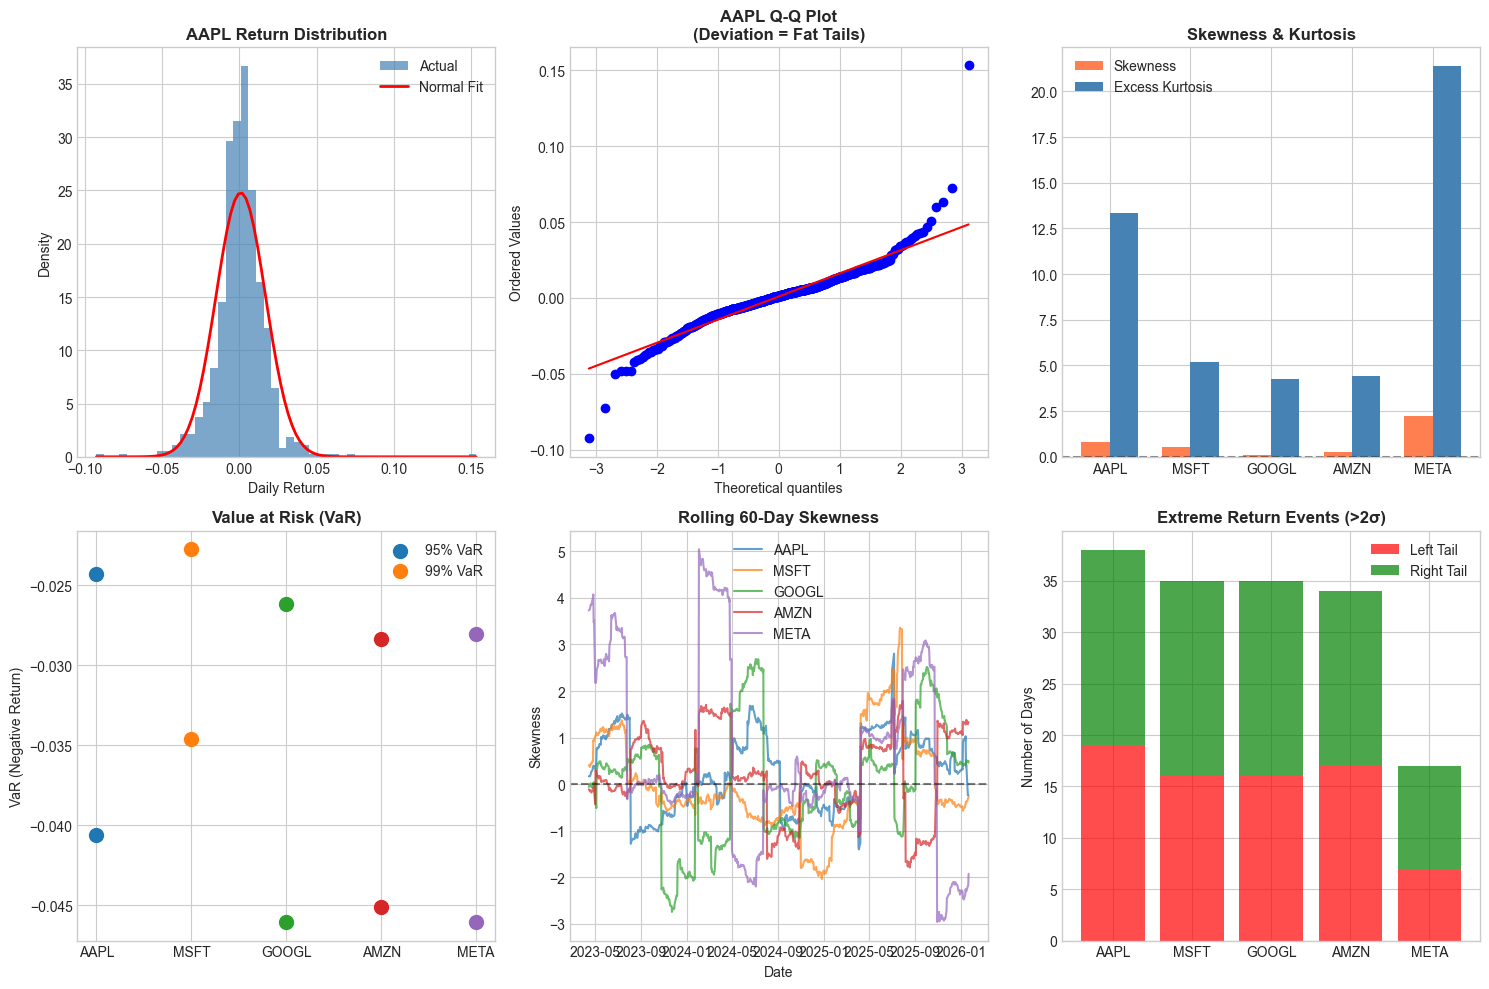

In [4]:
# ============================================================
# VISUALIZATION: Distribution Analysis
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Histogram with Normal Fit
ax1 = axes[0, 0]
ticker = TICKERS[0]
ret = returns[ticker]
ax1.hist(ret, bins=50, density=True, alpha=0.7, color='steelblue', label='Actual')

# Fit normal distribution
mu, std = ret.mean(), ret.std()
x = np.linspace(ret.min(), ret.max(), 100)
ax1.plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2, label='Normal Fit')
ax1.set_title(f'{ticker} Return Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Daily Return')
ax1.set_ylabel('Density')
ax1.legend()

# 2. QQ Plot
ax2 = axes[0, 1]
stats.probplot(ret, dist="norm", plot=ax2)
ax2.set_title(f'{ticker} Q-Q Plot\n(Deviation = Fat Tails)', fontsize=12, fontweight='bold')

# 3. Skewness & Kurtosis Comparison
ax3 = axes[0, 2]
skewness_vals = [dist_stats[t]['skewness'] for t in TICKERS]
kurtosis_vals = [dist_stats[t]['kurtosis'] for t in TICKERS]
x = np.arange(len(TICKERS))
width = 0.35
ax3.bar(x - width/2, skewness_vals, width, label='Skewness', color='coral')
ax3.bar(x + width/2, kurtosis_vals, width, label='Excess Kurtosis', color='steelblue')
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax3.set_xticks(x)
ax3.set_xticklabels(TICKERS)
ax3.set_title('Skewness & Kurtosis', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Tail Risk Analysis
ax4 = axes[1, 0]
for ticker in TICKERS:
    ret = returns[ticker]
    # Calculate empirical VaR at different levels
    var_95 = ret.quantile(0.05)
    var_99 = ret.quantile(0.01)
    ax4.scatter([ticker, ticker], [var_95, var_99], s=100)
ax4.set_title('Value at Risk (VaR)', fontsize=12, fontweight='bold')
ax4.set_ylabel('VaR (Negative Return)')
ax4.legend(['95% VaR', '99% VaR'])

# 5. Rolling Skewness
ax5 = axes[1, 1]
for ticker in TICKERS:
    rolling_skew = returns[ticker].rolling(60).apply(skew)
    ax5.plot(rolling_skew.index, rolling_skew.values, label=ticker, alpha=0.7)
ax5.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax5.set_title('Rolling 60-Day Skewness', fontsize=12, fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('Skewness')
ax5.legend()

# 6. Tail Returns Distribution
ax6 = axes[1, 2]
for ticker in TICKERS:
    ret = returns[ticker]
    # Get tail returns (beyond 2 std)
    left_tail = ret[ret < -2*ret.std()].count()
    right_tail = ret[ret > 2*ret.std()].count()
    ax6.bar(ticker, left_tail, color='red', alpha=0.7, label='Left Tail' if ticker == TICKERS[0] else '')
    ax6.bar(ticker, right_tail, bottom=left_tail, color='green', alpha=0.7, label='Right Tail' if ticker == TICKERS[0] else '')
ax6.set_title('Extreme Return Events (>2σ)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Number of Days')
ax6.legend()

plt.tight_layout()
plt.show()

---

## 📊 Section 2: Hypothesis Testing (Week 2 Concept)

**Tests we'll perform:**
1. **t-test:** Is mean return significantly different from zero?
2. **Sharpe Ratio test:** Is risk-adjusted return significant?
3. **Comparison test:** Are two stocks' returns significantly different?

**Why this matters:**
Just because a stock went up doesn't mean it has genuine alpha. We need statistical significance!

In [5]:
# ============================================================
# HYPOTHESIS TESTING
# ============================================================
from scipy.stats import ttest_1samp, ttest_ind

print("📊 HYPOTHESIS TESTING")
print("=" * 80)

# Test 1: Is mean return significantly different from zero?
print("\n🔬 TEST 1: Mean Return vs Zero")
print(f"{'Ticker':<10} {'Mean Return':>15} {'t-statistic':>15} {'p-value':>15} {'Significant?':>15}")
print("-" * 70)

hypothesis_results = {}
for ticker in TICKERS:
    ret = returns[ticker]
    t_stat, p_val = ttest_1samp(ret, 0)
    
    significant = "Yes ✅" if p_val < 0.05 else "No ❌"
    hypothesis_results[ticker] = {'t_stat': t_stat, 'p_val': p_val, 'significant': p_val < 0.05}
    
    print(f"{ticker:<10} {ret.mean():>14.4%} {t_stat:>15.3f} {p_val:>15.4f} {significant:>15}")

print("\n📈 Interpretation: p-value < 0.05 means we can reject the null hypothesis")
print("   that mean returns equal zero (statistically significant positive/negative returns)")

📊 HYPOTHESIS TESTING

🔬 TEST 1: Mean Return vs Zero
Ticker         Mean Return     t-statistic         p-value    Significant?
----------------------------------------------------------------------
AAPL              0.0959%           1.637          0.1020            No ❌
MSFT              0.0982%           1.863          0.0629            No ❌
GOOGL             0.1900%           2.745          0.0062           Yes ✅
AMZN              0.1388%           1.909          0.0567            No ❌
META              0.2366%           2.706          0.0070           Yes ✅

📈 Interpretation: p-value < 0.05 means we can reject the null hypothesis
   that mean returns equal zero (statistically significant positive/negative returns)


In [6]:
# ============================================================
# SHARPE RATIO SIGNIFICANCE TEST
# ============================================================

def sharpe_ratio_test(returns, rf=RISK_FREE_RATE/252):
    """Test if Sharpe ratio is significantly different from zero."""
    excess_returns = returns - rf
    n = len(returns)
    sharpe = excess_returns.mean() / returns.std() * np.sqrt(252)
    
    # Standard error of Sharpe ratio (Lo, 2002)
    se_sharpe = np.sqrt((1 + 0.5 * sharpe**2) / n) * np.sqrt(252)
    
    t_stat = sharpe / se_sharpe
    p_val = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
    return sharpe, se_sharpe, t_stat, p_val

print("\n🔬 TEST 2: Sharpe Ratio Significance")
print(f"{'Ticker':<10} {'Sharpe':>12} {'Std Error':>12} {'t-stat':>12} {'p-value':>12} {'Significant?':>15}")
print("-" * 75)

for ticker in TICKERS:
    sharpe, se, t_stat, p_val = sharpe_ratio_test(returns[ticker])
    significant = "Yes ✅" if p_val < 0.05 else "No ❌"
    print(f"{ticker:<10} {sharpe:>12.3f} {se:>12.3f} {t_stat:>12.3f} {p_val:>12.4f} {significant:>15}")


🔬 TEST 2: Sharpe Ratio Significance
Ticker           Sharpe    Std Error       t-stat      p-value    Significant?
---------------------------------------------------------------------------
AAPL              0.750        0.654        1.147       0.2513            No ❌
MSFT              0.859        0.676        1.271       0.2038            No ❌
GOOGL             1.420        0.819        1.735       0.0828            No ❌
AMZN              0.945        0.695        1.360       0.1738            No ❌
META              1.432        0.822        1.742       0.0815            No ❌


In [7]:
# ============================================================
# PAIRWISE COMPARISON TEST
# ============================================================

print("\n🔬 TEST 3: Pairwise Return Comparison")
print("Testing if returns are significantly different between pairs:")
print("-" * 60)

# Compare each stock to benchmark
for ticker in TICKERS:
    t_stat, p_val = ttest_ind(returns[ticker], returns[BENCHMARK])
    significant = "Yes" if p_val < 0.05 else "No"
    diff = returns[ticker].mean() - returns[BENCHMARK].mean()
    print(f"{ticker} vs {BENCHMARK}: Diff={diff:.4%}, p-val={p_val:.4f}, Different={significant}")


🔬 TEST 3: Pairwise Return Comparison
Testing if returns are significantly different between pairs:
------------------------------------------------------------
AAPL vs SPY: Diff=0.0111%, p-val=0.8702, Different=No
MSFT vs SPY: Diff=0.0135%, p-val=0.8312, Different=No
GOOGL vs SPY: Diff=0.1052%, p-val=0.1750, Different=No
AMZN vs SPY: Diff=0.0541%, p-val=0.5030, Different=No
META vs SPY: Diff=0.1519%, p-val=0.1070, Different=No


---

## 📊 Section 3: Z-Score Mean Reversion Strategy (Week 2 Concept)

**Strategy Logic:**
- Calculate rolling z-score: $z = \frac{P_t - \mu}{\sigma}$
- **Buy:** When z-score < -2 (oversold)
- **Sell:** When z-score > +2 (overbought)

**Why this matters:**
Z-scores normalize price movements. Extreme z-scores suggest mean reversion opportunities.

In [8]:
# ============================================================
# Z-SCORE MEAN REVERSION STRATEGY
# ============================================================

def calculate_z_score(prices, window=20):
    """Calculate rolling z-score."""
    rolling_mean = prices.rolling(window).mean()
    rolling_std = prices.rolling(window).std()
    z_score = (prices - rolling_mean) / rolling_std
    return z_score

def z_score_signals(prices, z_threshold=2.0, window=20):
    """Generate mean reversion signals based on z-score."""
    z = calculate_z_score(prices, window)
    
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices
    signals['z_score'] = z
    
    # Signal: 1 when oversold (z < -threshold), -1 when overbought (z > threshold)
    signals['signal'] = 0
    signals.loc[z < -z_threshold, 'signal'] = 1   # Buy when oversold
    signals.loc[z > z_threshold, 'signal'] = -1   # Sell when overbought
    
    return signals

# Generate z-score signals
z_signals = {}
for ticker in TICKERS:
    z_signals[ticker] = z_score_signals(prices[ticker], Z_SCORE_THRESHOLD)

print(f"📊 Z-SCORE MEAN REVERSION SIGNALS (Threshold: ±{Z_SCORE_THRESHOLD})")
print("=" * 60)

for ticker in TICKERS:
    signals = z_signals[ticker]
    current_z = signals['z_score'].iloc[-1]
    buy_signals = (signals['signal'] == 1).sum()
    sell_signals = (signals['signal'] == -1).sum()
    
    if current_z < -Z_SCORE_THRESHOLD:
        status = "🟢 OVERSOLD (BUY)"
    elif current_z > Z_SCORE_THRESHOLD:
        status = "🔴 OVERBOUGHT (SELL)"
    else:
        status = "⚪ NEUTRAL"
    
    print(f"{ticker}: Z-score={current_z:.2f}, Buy signals={buy_signals}, Sell signals={sell_signals}, Status: {status}")

📊 Z-SCORE MEAN REVERSION SIGNALS (Threshold: ±2.0)
AAPL: Z-score=-1.51, Buy signals=35, Sell signals=47, Status: ⚪ NEUTRAL
MSFT: Z-score=-1.82, Buy signals=25, Sell signals=52, Status: ⚪ NEUTRAL
GOOGL: Z-score=0.97, Buy signals=22, Sell signals=62, Status: ⚪ NEUTRAL
AMZN: Z-score=-0.36, Buy signals=21, Sell signals=55, Status: ⚪ NEUTRAL
META: Z-score=-0.32, Buy signals=22, Sell signals=59, Status: ⚪ NEUTRAL


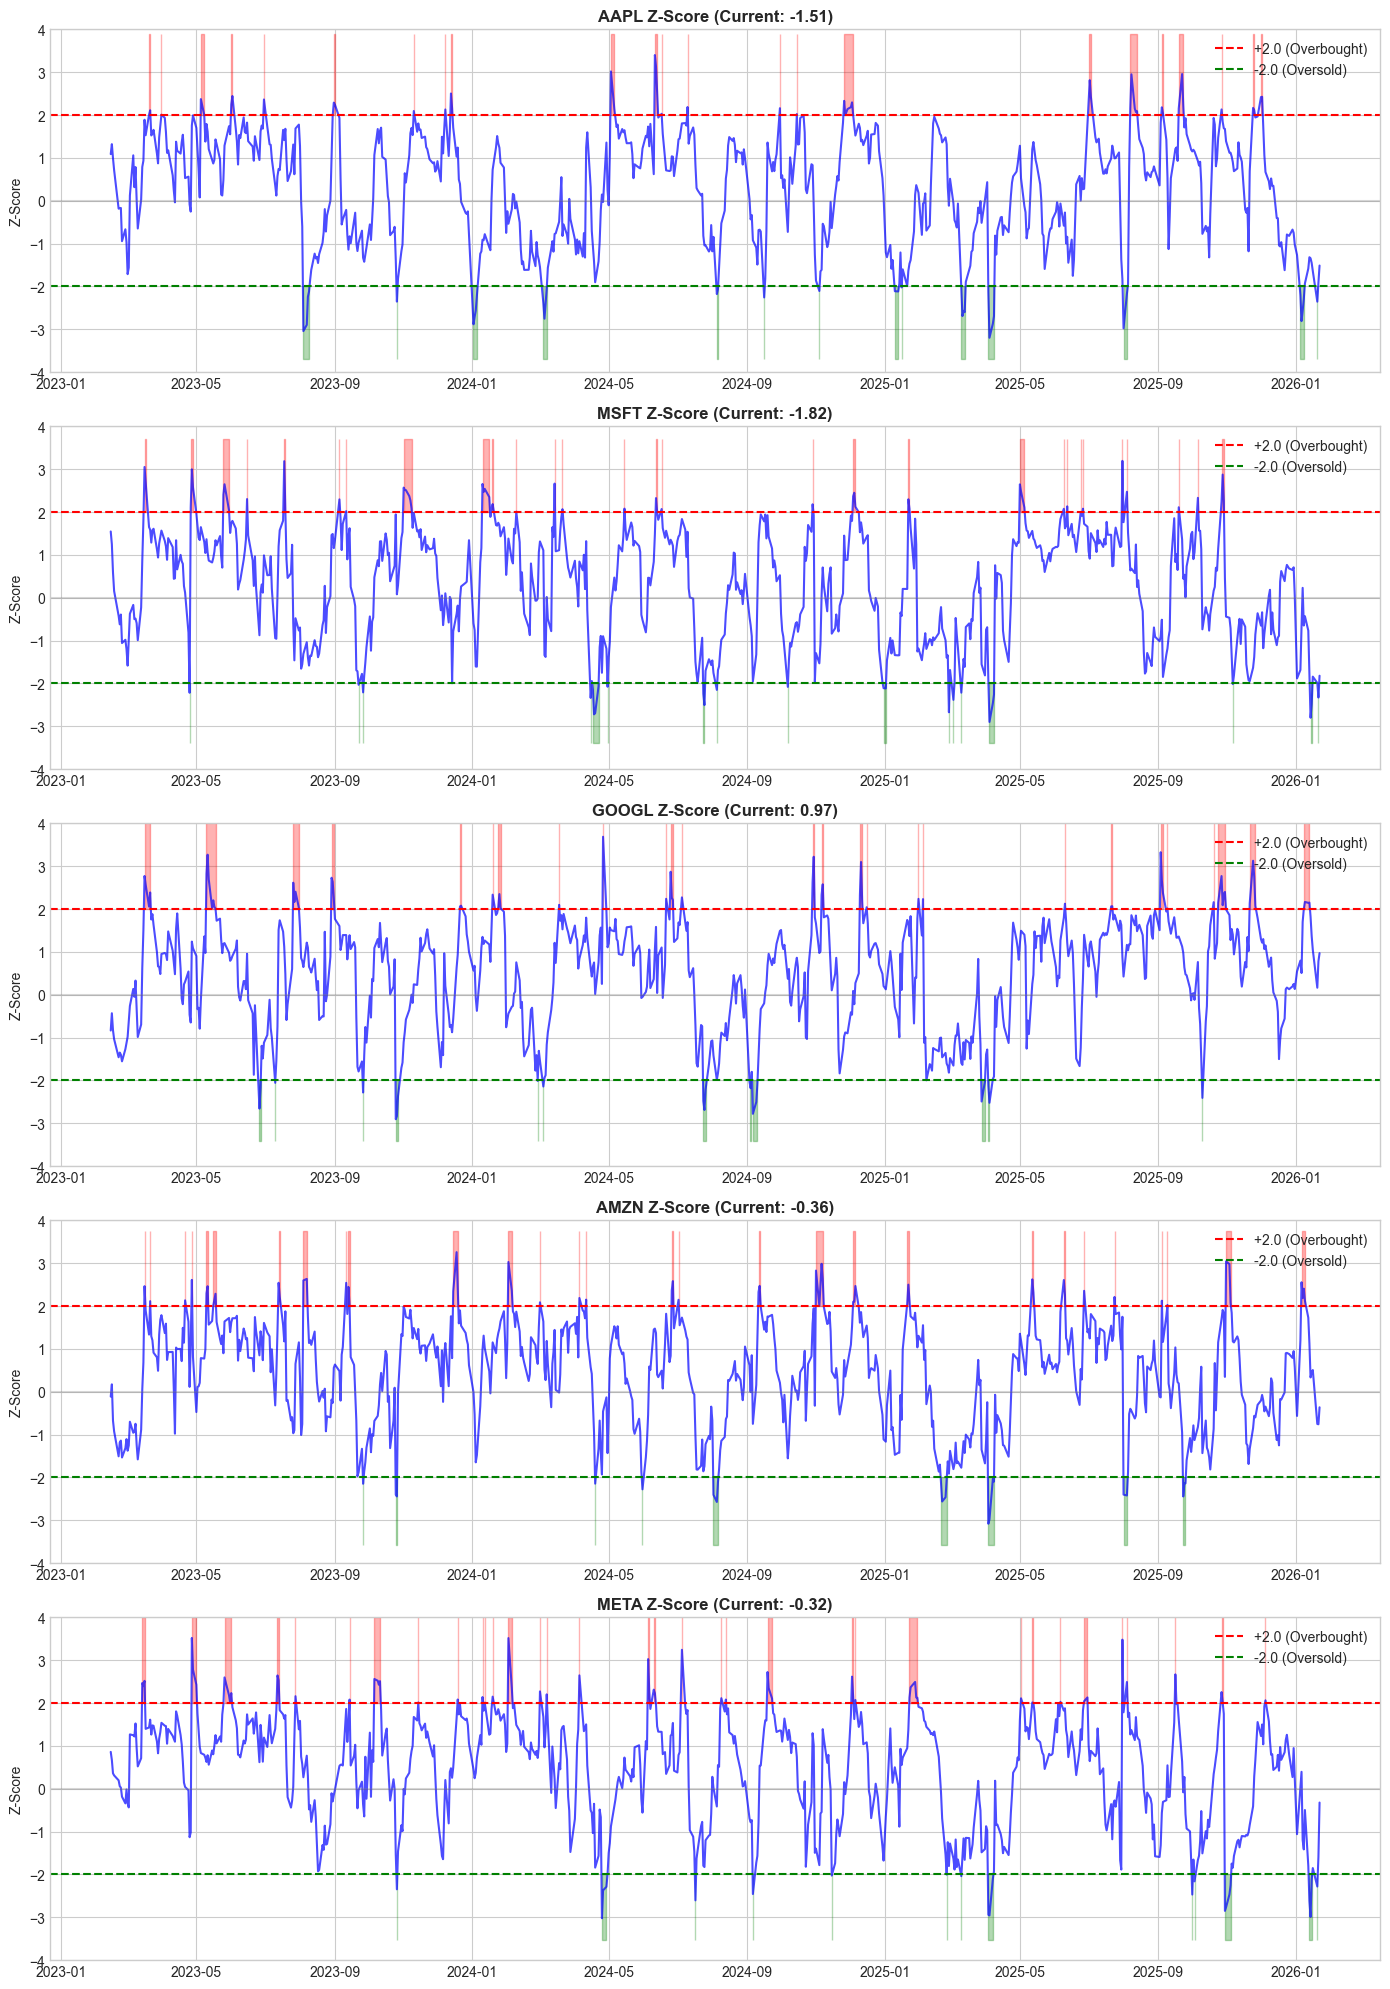

In [9]:
# ============================================================
# VISUALIZATION: Z-Score Strategy
# ============================================================

fig, axes = plt.subplots(len(TICKERS), 1, figsize=(14, 4*len(TICKERS)))

for i, ticker in enumerate(TICKERS):
    ax = axes[i] if len(TICKERS) > 1 else axes
    signals = z_signals[ticker]
    
    # Plot z-score
    ax.plot(signals.index, signals['z_score'], 'b-', alpha=0.7)
    ax.axhline(y=Z_SCORE_THRESHOLD, color='r', linestyle='--', label=f'+{Z_SCORE_THRESHOLD} (Overbought)')
    ax.axhline(y=-Z_SCORE_THRESHOLD, color='g', linestyle='--', label=f'-{Z_SCORE_THRESHOLD} (Oversold)')
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    # Fill regions
    ax.fill_between(signals.index, Z_SCORE_THRESHOLD, signals['z_score'].max() + 0.5, 
                    where=signals['z_score'] > Z_SCORE_THRESHOLD, alpha=0.3, color='red')
    ax.fill_between(signals.index, -Z_SCORE_THRESHOLD, signals['z_score'].min() - 0.5, 
                    where=signals['z_score'] < -Z_SCORE_THRESHOLD, alpha=0.3, color='green')
    
    ax.set_title(f'{ticker} Z-Score (Current: {signals["z_score"].iloc[-1]:.2f})', fontsize=12, fontweight='bold')
    ax.set_ylabel('Z-Score')
    ax.legend(loc='upper right')
    ax.set_ylim(-4, 4)

plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# BACKTEST Z-SCORE STRATEGY
# ============================================================

def backtest_z_score_strategy(prices, signals, initial_capital=100000):
    """Backtest z-score mean reversion strategy."""
    returns = prices.pct_change()
    
    # Position: hold until opposite signal
    position = signals['signal'].replace(0, np.nan).ffill().fillna(0)
    
    # Strategy returns
    strategy_returns = returns * position.shift(1)
    
    # Cumulative returns
    buy_hold_cum = (1 + returns).cumprod()
    strategy_cum = (1 + strategy_returns).cumprod()
    
    return {
        'buy_hold_return': buy_hold_cum.iloc[-1] - 1,
        'strategy_return': strategy_cum.iloc[-1] - 1,
        'strategy_cum': strategy_cum,
        'buy_hold_cum': buy_hold_cum
    }

# Backtest all tickers
z_backtest = {}
for ticker in TICKERS:
    z_backtest[ticker] = backtest_z_score_strategy(prices[ticker], z_signals[ticker])

print("📊 Z-SCORE STRATEGY BACKTEST")
print("=" * 70)
print(f"{'Ticker':<10} {'Buy & Hold':>15} {'Z-Score Strategy':>18} {'Outperformance':>18}")
print("-" * 70)

for ticker in TICKERS:
    bh = z_backtest[ticker]['buy_hold_return']
    strat = z_backtest[ticker]['strategy_return']
    outperf = strat - bh
    print(f"{ticker:<10} {bh:>14.2%} {strat:>17.2%} {outperf:>17.2%}")

📊 Z-SCORE STRATEGY BACKTEST
Ticker          Buy & Hold   Z-Score Strategy     Outperformance
----------------------------------------------------------------------
AAPL               87.18%           -15.61%          -102.79%
MSFT               94.00%           -12.47%          -106.47%
GOOGL             265.88%           -34.67%          -300.55%
AMZN              145.33%            -0.54%          -145.87%
META              382.74%           -26.90%          -409.64%


---

## 📊 Section 4: Confidence Intervals for Risk Management (Week 2 Concept)

**What we're calculating:**
- Confidence intervals for expected returns
- Value at Risk (VaR) with confidence levels
- Conditional VaR (Expected Shortfall)

**Why this matters:**
Confidence intervals quantify uncertainty. VaR tells us the worst expected loss at a given confidence level.

In [11]:
# ============================================================
# CONFIDENCE INTERVALS & VAR
# ============================================================

def calculate_var_cvar(returns, confidence=0.95):
    """Calculate VaR and CVaR."""
    var = returns.quantile(1 - confidence)
    cvar = returns[returns <= var].mean()
    return var, cvar

print("📊 RISK METRICS WITH CONFIDENCE INTERVALS")
print("=" * 80)
print(f"\n{'Ticker':<10} {'95% VaR':>12} {'99% VaR':>12} {'95% CVaR':>12} {'CI Low':>12} {'CI High':>12}")
print("-" * 80)

risk_metrics = {}
for ticker in TICKERS:
    ret = returns[ticker]
    
    # VaR and CVaR
    var_95, cvar_95 = calculate_var_cvar(ret, 0.95)
    var_99, cvar_99 = calculate_var_cvar(ret, 0.99)
    
    # Confidence interval for mean return
    n = len(ret)
    se = ret.std() / np.sqrt(n)
    ci_low = ret.mean() - 1.96 * se
    ci_high = ret.mean() + 1.96 * se
    
    risk_metrics[ticker] = {
        'var_95': var_95, 'var_99': var_99, 
        'cvar_95': cvar_95, 'ci_low': ci_low, 'ci_high': ci_high
    }
    
    print(f"{ticker:<10} {var_95:>11.2%} {var_99:>11.2%} {cvar_95:>11.2%} {ci_low:>11.4%} {ci_high:>11.4%}")

print("\n📈 Interpretation:")
print("   - VaR 95%: 5% chance of losing more than this amount")
print("   - CVaR: Average loss when VaR is breached")
print("   - CI: 95% confident true mean return is in this range")

📊 RISK METRICS WITH CONFIDENCE INTERVALS

Ticker          95% VaR      99% VaR     95% CVaR       CI Low      CI High
--------------------------------------------------------------------------------
AAPL            -2.43%      -4.06%      -3.59%    -0.0189%     0.2107%
MSFT            -2.27%      -3.46%      -3.02%    -0.0051%     0.2016%
GOOGL           -2.62%      -4.60%      -4.11%     0.0543%     0.3256%
AMZN            -2.84%      -4.51%      -4.27%    -0.0037%     0.2814%
META            -2.81%      -4.60%      -4.46%     0.0652%     0.4080%

📈 Interpretation:
   - VaR 95%: 5% chance of losing more than this amount
   - CVaR: Average loss when VaR is breached
   - CI: 95% confident true mean return is in this range


In [12]:
# ============================================================
# FINAL SUMMARY & RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 2 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Create summary
summary = pd.DataFrame(index=TICKERS)
summary['Mean Return'] = [returns[t].mean() for t in TICKERS]
summary['Significant?'] = [hypothesis_results[t]['significant'] for t in TICKERS]
summary['Skewness'] = [dist_stats[t]['skewness'] for t in TICKERS]
summary['Kurtosis'] = [dist_stats[t]['kurtosis'] for t in TICKERS]
summary['Z-Score'] = [z_signals[t]['z_score'].iloc[-1] for t in TICKERS]
summary['95% VaR'] = [risk_metrics[t]['var_95'] for t in TICKERS]

# Trading signals
def get_signal(row):
    if row['Z-Score'] < -Z_SCORE_THRESHOLD:
        return "🟢 BUY (Oversold)"
    elif row['Z-Score'] > Z_SCORE_THRESHOLD:
        return "🔴 SELL (Overbought)"
    else:
        return "⚪ HOLD"

summary['Signal'] = summary.apply(get_signal, axis=1)

print("\n📋 STOCK ANALYSIS:")
print(summary.round(4).to_string())

# Recommendations
print("\n🏆 RECOMMENDATIONS:")
oversold = summary[summary['Z-Score'] < -Z_SCORE_THRESHOLD].index.tolist()
overbought = summary[summary['Z-Score'] > Z_SCORE_THRESHOLD].index.tolist()

print(f"\n1. 🟢 OVERSOLD (Consider Buying): {oversold if oversold else 'None'}")
print(f"2. 🔴 OVERBOUGHT (Consider Selling): {overbought if overbought else 'None'}")

# Best risk-adjusted
lowest_var = summary['95% VaR'].idxmax()  # Least negative VaR
print(f"3. 🛡️ LOWEST RISK: {lowest_var} (VaR: {summary.loc[lowest_var, '95% VaR']:.2%})")

# Statistically significant positive returns
sig_positive = summary[(summary['Significant?'] == True) & (summary['Mean Return'] > 0)].index.tolist()
print(f"4. ✅ SIGNIFICANT POSITIVE RETURNS: {sig_positive if sig_positive else 'None'}")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 2 STRATEGY - FINAL RECOMMENDATIONS

📋 STOCK ANALYSIS:
       Mean Return  Significant?  Skewness  Kurtosis  Z-Score  95% VaR  Signal
AAPL        0.0010         False    0.8360   13.3160  -1.5117  -0.0243  ⚪ HOLD
MSFT        0.0010         False    0.5312    5.1651  -1.8195  -0.0227  ⚪ HOLD
GOOGL       0.0019          True    0.0945    4.2690   0.9726  -0.0262  ⚪ HOLD
AMZN        0.0014         False    0.2377    4.4296  -0.3622  -0.0284  ⚪ HOLD
META        0.0024          True    2.2426   21.3653  -0.3212  -0.0281  ⚪ HOLD

🏆 RECOMMENDATIONS:

1. 🟢 OVERSOLD (Consider Buying): None
2. 🔴 OVERBOUGHT (Consider Selling): None
3. 🛡️ LOWEST RISK: MSFT (VaR: -2.27%)
4. ✅ SIGNIFICANT POSITIVE RETURNS: ['GOOGL', 'META']

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1 + Week 2)

| Week | Concept | How We Used It |
|------|---------|----------------|
| 1 | Returns & Volatility | Base metrics calculation |
| 1 | Correlation | Diversification analysis |
| **2** | **Distribution Analysis** | **Skewness, kurtosis, normality tests** |
| **2** | **Hypothesis Testing** | **t-tests for significance** |
| **2** | **Confidence Intervals** | **Risk quantification** |
| **2** | **Z-Score** | **Mean reversion signals** |

---

## 🚀 Next Steps (Week 3+)

Building on this foundation:
- Week 3: Time series analysis (ARIMA forecasting)
- Week 4: Machine learning basics
- Week 5+: Advanced models

---